# **Задача обучения (соревнования)** - построить модель определения цены жилой недвижимости на основе представленного набора данных

Проект выполнен в рамках участия в ШИФТ Интенсиве по направлению ML Classic.

Проект подготовлен командой Русичи: Владислав Вольников, [Станислав Кацко](https://t.me/StanislavKatsko), Иван Литвинов.

Соревнование проходило на сайте [CodaLab](https://codalab.lisn.upsaclay.fr/competitions/19541?secret_key=8bb366ef-36d6-4587-a309-ed9fcbcd88f5)

На первом этапе в представленном ноутбуке (Русичи_EDA) мы загружаем исходные данные и проводим разведочный анализ данных (EDA).

Во втором ноутбуке (Русичи_model) будут представлены процессы предобработки данных, обучения и сабмита.

# Подключаемся к Google Drive и импортируем библиотеки

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load data libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data preparation
from sklearn.preprocessing import RobustScaler, StandardScaler
from datetime import datetime
import math

# Modeling
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, r2_score, precision_score, recall_score, classification_report, confusion_matrix


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
import os

import pandas as pd

# Загружаем DataFrame и начинаем исследование данных

In [ ]:
df = pd.read_csv('./gdrive/MyDrive/SHIFT_SUMMER/train.csv', index_col=0)
df

,full_sq,floor,build_year,num_room,kitch_sq,state,product_type,raion_popul,indust_part,sport_objects_raion,...,cafe_count_1000_price_high,cafe_sum_1500_min_price_avg,green_part_2000,cafe_sum_2000_min_price_avg,mosque_count_3000,prom_part_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,year,price_doc
0,43,24.0,2014.0,1.0,10.0,1.0,1,8.294300,0.007122,0,...,0,6.907755,3.710396,6.725430,0,1.803359,6.616560,0,2014,5533460
1,66,3.0,1979.0,3.0,10.0,3.0,0,11.314231,0.232205,4,...,0,6.626122,2.764431,6.479615,1,2.631169,6.469948,1,2013,9900000
2,55,5.0,1979.0,2.0,6.0,2.0,0,11.718817,0.000170,5,...,0,6.368753,3.511844,6.192138,0,1.363537,6.462171,0,2012,1990000
3,45,7.0,1970.0,2.0,6.0,2.0,0,11.331032,0.428826,4,...,0,6.753601,1.814825,6.551080,0,2.732418,6.458229,0,2014,6500000
4,43,4.0,1968.0,2.0,6.0,2.0,0,11.538769,0.136330,6,...,0,6.636603,2.257588,6.646507,1,2.020222,6.634778,2,2014,8500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21324,56,19.0,1979.0,2.0,1.0,1.0,1,11.655744,0.049637,6,...,0,6.492240,2.711378,6.816188,0,3.297317,6.536155,0,2014,10159562
21325,42,5.0,1977.0,1.0,8.0,3.0,0,11.718817,0.000170,5,...,0,6.502295,3.802208,6.291569,0,1.442202,6.487684,0,2014,5100000
21326,32,3.0,1979.0,2.0,6.0,2.0,0,11.719940,0.000000,4,...,0,6.572814,3.062456,6.583520,1,2.733718,6.573904,2,2011,4800000
21327,43,4.0,1969.0,2.0,5.0,2.0,0,11.331032,0.428826,4,...,0,6.586172,2.408745,6.563982,0,3.034953,6.476311,0,2013,6300000


Видим, что набор данных включает 50 характеристик 21329 объектов недвижимости.

В последнем столбце расположены значения целевой переменной (цены недвижимости).

In [ ]:
# Мы видим, что данные во всем датафрейме имеют числовой тип.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21329 entries, 0 to 21328
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   full_sq                      21329 non-null  int64  
 1   floor                        21329 non-null  float64
 2   build_year                   21329 non-null  float64
 3   num_room                     21329 non-null  float64
 4   kitch_sq                     21329 non-null  float64
 5   state                        21329 non-null  float64
 6   product_type                 21329 non-null  int64  
 7   raion_popul                  21329 non-null  float64
 8   indust_part                  21329 non-null  float64
 9   sport_objects_raion          21329 non-null  int64  
 10  shopping_centers_raion       21329 non-null  int64  
 11  radiation_raion              21329 non-null  int64  
 12  build_count_block            21329 non-null  float64
 13  build_count_brick    

In [ ]:
# Проверяем, что в данных нет пропусков.
df.isnull().sum()

full_sq                        0
floor                          0
build_year                     0
num_room                       0
kitch_sq                       0
state                          0
product_type                   0
raion_popul                    0
indust_part                    0
sport_objects_raion            0
shopping_centers_raion         0
radiation_raion                0
build_count_block              0
build_count_brick              0
build_count_monolith           0
metro_min_avto                 0
school_km                      0
green_zone_km                  0
industrial_km                  0
water_treatment_km             0
cemetery_km                    0
incineration_km                0
ID_railroad_station_avto       0
mkad_km                        0
ttk_km                         0
oil_chemistry_km               0
nuclear_reactor_km             0
power_transmission_line_km     0
market_shop_km                 0
fitness_km                     0
stadium_km

In [ ]:
# Посмотрим описание данных, чтобы получить общее представление.
df.describe()

,full_sq,floor,build_year,num_room,kitch_sq,state,product_type,raion_popul,indust_part,sport_objects_raion,...,cafe_count_1000_price_high,cafe_sum_1500_min_price_avg,green_part_2000,cafe_sum_2000_min_price_avg,mosque_count_3000,prom_part_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,year,price_doc
count,21329.000000,21329.000000,2.132900e+04,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,...,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,2.132900e+04
mean,54.088799,7.660509,2.864657e+03,1.938300,6.292184,2.061606,0.359276,10.899731,0.119305,6.581884,...,0.059028,6.535018,2.749243,6.545043,0.197900,2.170806,6.622740,0.442496,2013.449388,7.117599e+06
std,42.559522,5.319822,1.372879e+05,0.710045,23.847677,0.667929,0.479800,1.151518,0.119186,6.514278,...,0.325858,0.252222,0.870977,0.244766,0.445642,0.619349,0.177794,0.607982,0.961555,4.706342e+06
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,7.842279,0.000000,0.000000,...,0.000000,5.703782,-4.605170,5.703782,0.000000,-1.560648,5.703782,0.000000,2011.000000,1.000000e+05
25%,38.000000,3.000000,1.976000e+03,2.000000,5.000000,2.000000,0.000000,9.990536,0.019509,1.000000,...,0.000000,6.402862,2.314514,6.422240,0.000000,1.801710,6.509022,0.000000,2013.000000,4.745995e+06
50%,49.000000,6.500000,1.979000e+03,2.000000,6.000000,2.000000,0.000000,11.332626,0.072158,5.000000,...,0.000000,6.540034,2.865054,6.526978,0.000000,2.195000,6.581665,0.000000,2014.000000,6.255454e+06
75%,63.000000,11.000000,1.983000e+03,2.000000,8.000000,2.000000,1.000000,11.718817,0.195781,10.000000,...,0.000000,6.668863,3.341447,6.659294,0.000000,2.636912,6.703654,1.000000,2014.000000,8.300000e+06
max,5326.000000,77.000000,2.005201e+07,19.000000,2013.000000,33.000000,1.000000,12.419041,0.521867,29.000000,...,6.000000,7.824046,4.321480,7.680947,2.000000,3.352007,7.536364,2.000000,2015.000000,8.077744e+07


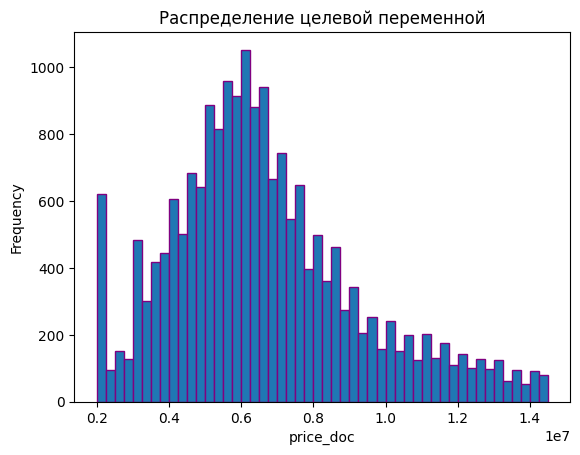

In [ ]:
# Посмотрим, как распределена целевая переменная.

import matplotlib.pyplot as plt

low= df['price_doc'].quantile(0.05)
upper = df['price_doc'].quantile(0.95)
new = df[(df['price_doc'] >= low) & (df['price_doc'] <= upper)]
plt.hist(new['price_doc'], bins=50, edgecolor='purple')
plt.title('Распределение целевой переменной')
plt.xlabel('price_doc')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Посмотрим названия всех характеристик, чтобы в дальнейшем проводить предобработку.
columns = df.columns.tolist()
features = columns
features

['full_sq', 'floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'raion_popul', 'indust_part', 'sport_objects_raion', 'shopping_centers_raion', 'radiation_raion', 'build_count_block', 'build_count_brick', 'build_count_monolith', 'metro_min_avto', 'school_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'ID_railroad_station_avto', 'mkad_km', 'ttk_km', 'oil_chemistry_km', 'nuclear_reactor_km', 'power_transmission_line_km', 'market_shop_km', 'fitness_km', 'stadium_km', 'basketball_km', 'detention_facility_km', 'additional_education_km', 'big_church_km', 'mosque_km', 'theater_km', 'exhibition_km', 'catering_km', 'green_part_1000', 'cafe_sum_1000_min_price_avg', 'cafe_count_1000_price_high', 'cafe_sum_1500_min_price_avg', 'green_part_2000', 'cafe_sum_2000_min_price_avg', 'mosque_count_3000', 'prom_part_5000', 'cafe_sum_5000_min_price_avg', 'mosque_count_5000', 'year', 'price_doc']


In [ ]:
# Создаем новую таблицу, копируя указанные признаки из исходной таблицы
# вместе с целевым признаком.

def copy_by_feature(df, features):
  df_copy = pd.DataFrame()
  for feature in features:
    df_copy[feature] = df[feature]
  df_copy["price_doc"] = df['price_doc']
  return df_copy

In [ ]:
# Делим все признаки на 5 групп по 10 признаков в каждой.

features1 = features[0:10]
features2 = features[10:20]
features3 = features[20:30]
features4 = features[30:40]
features5 = features[40:50]

In [ ]:
df_1 = copy_by_feature(df, features1)
df_2 = copy_by_feature(df, features2)
df_3 = copy_by_feature(df, features3)
df_4 = copy_by_feature(df, features4)
df_5 = copy_by_feature(df, features5)

Посмотрим характеристики объектов в каждой выделенной группе.

In [ ]:
df_1.describe()

,full_sq,floor,build_year,num_room,kitch_sq,state,product_type,raion_popul,indust_part,sport_objects_raion,price_doc
count,21329.000000,21329.000000,2.132900e+04,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,2.132900e+04
mean,54.088799,7.660509,2.864657e+03,1.938300,6.292184,2.061606,0.359276,10.899731,0.119305,6.581884,7.117599e+06
std,42.559522,5.319822,1.372879e+05,0.710045,23.847677,0.667929,0.479800,1.151518,0.119186,6.514278,4.706342e+06
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,7.842279,0.000000,0.000000,1.000000e+05
25%,38.000000,3.000000,1.976000e+03,2.000000,5.000000,2.000000,0.000000,9.990536,0.019509,1.000000,4.745995e+06
50%,49.000000,6.500000,1.979000e+03,2.000000,6.000000,2.000000,0.000000,11.332626,0.072158,5.000000,6.255454e+06
75%,63.000000,11.000000,1.983000e+03,2.000000,8.000000,2.000000,1.000000,11.718817,0.195781,10.000000,8.300000e+06
max,5326.000000,77.000000,2.005201e+07,19.000000,2013.000000,33.000000,1.000000,12.419041,0.521867,29.000000,8.077744e+07


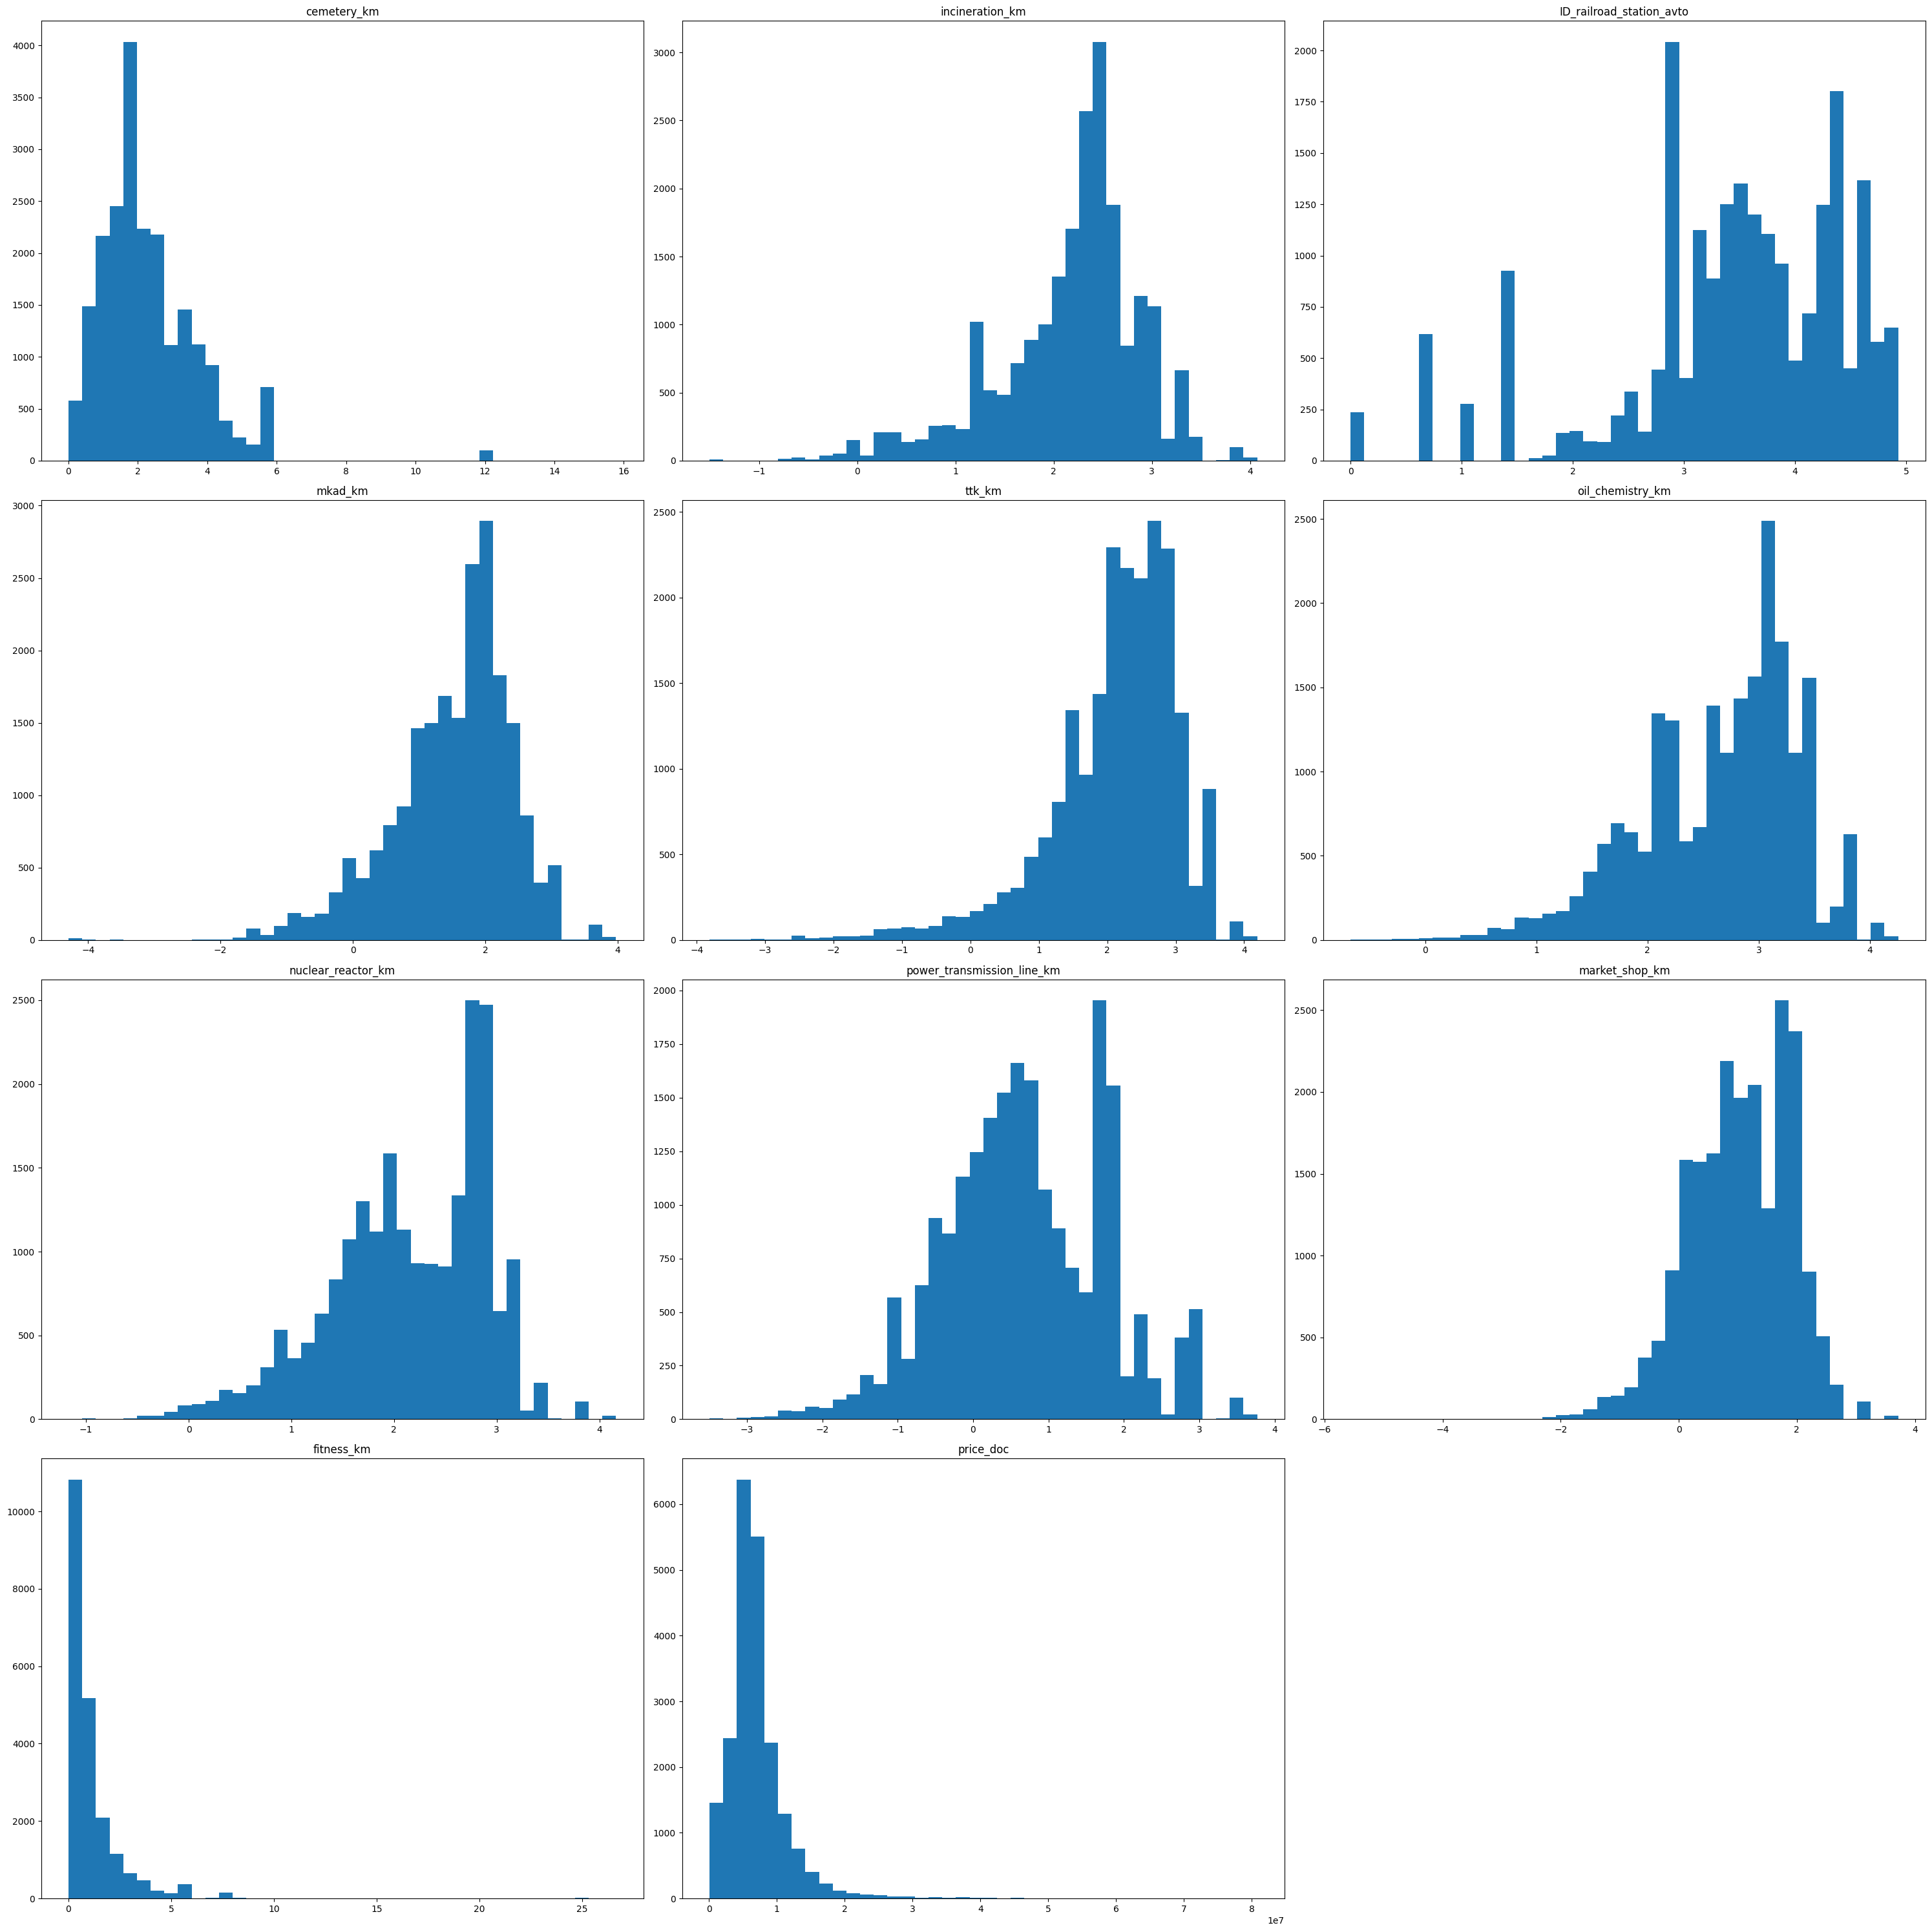

In [ ]:
df_3.hist(figsize=(30,30), bins=40, grid=False)
plt.tight_layout()

In [ ]:
df_2.describe()

,shopping_centers_raion,radiation_raion,build_count_block,build_count_brick,build_count_monolith,metro_min_avto,school_km,green_zone_km,industrial_km,water_treatment_km,price_doc
count,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,2.132900e+04
mean,4.171832,0.354259,49.037976,100.645975,10.982559,4.991885,1.327772,0.302356,0.768502,2.095649,7.117599e+06
std,4.730773,0.478300,43.030509,117.744957,17.767365,6.608485,3.041464,0.300337,0.718222,0.961112,4.706342e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.009021,0.000000,0.000000,0.000000,-1.294120,1.000000e+05
25%,1.000000,0.000000,18.000000,16.000000,3.000000,1.721263,0.270784,0.101285,0.288289,1.663562,4.745995e+06
50%,3.000000,0.000000,42.000000,67.000000,6.000000,2.804365,0.477178,0.214474,0.574383,2.339692,6.255454e+06
75%,6.000000,1.000000,66.000000,126.000000,11.000000,4.832712,0.887192,0.417202,1.040797,2.822017,8.300000e+06
max,23.000000,1.000000,223.000000,664.000000,127.000000,61.438472,47.394706,1.982448,14.048162,3.862649,8.077744e+07


In [ ]:
df_3.describe()

,cemetery_km,incineration_km,ID_railroad_station_avto,mkad_km,ttk_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,market_shop_km,fitness_km,price_doc
count,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,2.132900e+04
mean,2.309772,2.168862,3.430676,1.506960,2.111913,2.650759,2.145977,0.690271,1.042905,1.155302,7.117599e+06
std,1.445623,0.729668,1.048065,0.906977,0.936051,0.697254,0.762523,1.074492,0.866015,1.535428,4.706342e+06
min,0.000000,-1.504110,0.000000,-4.295762,-3.813639,-0.671953,-1.171794,-3.497732,-5.560424,0.000000,1.000000e+05
25%,1.336053,1.819042,2.944439,0.976851,1.672790,2.169075,1.653375,-0.019477,0.436600,0.360182,4.745995e+06
50%,1.963061,2.333840,3.526361,1.710063,2.287870,2.811528,2.195154,0.646235,1.078111,0.654430,6.255454e+06
75%,3.067517,2.598617,4.290459,2.102273,2.752096,3.153783,2.795604,1.594639,1.709141,1.333994,8.300000e+06
max,15.778710,4.071281,4.927254,3.975520,4.190158,4.254384,4.162890,3.768715,3.716097,26.652505,8.077744e+07


In [ ]:
df_4.describe()

,stadium_km,basketball_km,detention_facility_km,additional_education_km,big_church_km,mosque_km,theater_km,exhibition_km,catering_km,green_part_1000,price_doc
count,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,2.132900e+04
mean,1.936984,1.043448,2.343118,1.327968,0.393166,1.787875,1.978835,1.345166,-0.918657,16.938400,7.117599e+06
std,0.835306,1.073377,0.900849,1.520137,0.968606,0.762706,0.834164,0.907355,1.117162,14.607117,4.706342e+06
min,-2.165038,-5.210630,-3.188660,0.000000,-5.503652,-5.194945,-3.619798,-4.716181,-7.938627,0.000000,1.000000e+05
25%,1.390835,0.267047,1.732764,0.473349,-0.149911,1.326032,1.448006,0.810275,-1.565852,6.260000,4.745995e+06
50%,1.951334,1.055415,2.440538,0.900319,0.404499,1.874393,2.153157,1.415344,-0.888820,12.950000,6.255454e+06
75%,2.609465,1.855079,3.218377,1.564696,1.073952,2.306243,2.599404,1.946334,-0.182727,24.160000,8.300000e+06
max,4.423630,4.037841,4.492800,24.268209,3.821421,3.803320,4.472789,3.996938,2.498374,100.000000,8.077744e+07


In [ ]:
df_5.describe()

,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,cafe_sum_1500_min_price_avg,green_part_2000,cafe_sum_2000_min_price_avg,mosque_count_3000,prom_part_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,year,price_doc
count,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,2.132900e+04
mean,6.515025,0.059028,6.535018,2.749243,6.545043,0.197900,2.170806,6.622740,0.442496,2013.449388,7.117599e+06
std,0.276715,0.325858,0.252222,0.870977,0.244766,0.445642,0.619349,0.177794,0.607982,0.961555,4.706342e+06
min,5.703782,0.000000,5.703782,-4.605170,5.703782,0.000000,-1.560648,5.703782,0.000000,2011.000000,1.000000e+05
25%,6.384030,0.000000,6.402862,2.314514,6.422240,0.000000,1.801710,6.509022,0.000000,2013.000000,4.745995e+06
50%,6.506128,0.000000,6.540034,2.865054,6.526978,0.000000,2.195000,6.581665,0.000000,2014.000000,6.255454e+06
75%,6.659294,0.000000,6.668863,3.341447,6.659294,0.000000,2.636912,6.703654,1.000000,2014.000000,8.300000e+06
max,7.824046,6.000000,7.824046,4.321480,7.680947,2.000000,3.352007,7.536364,2.000000,2015.000000,8.077744e+07


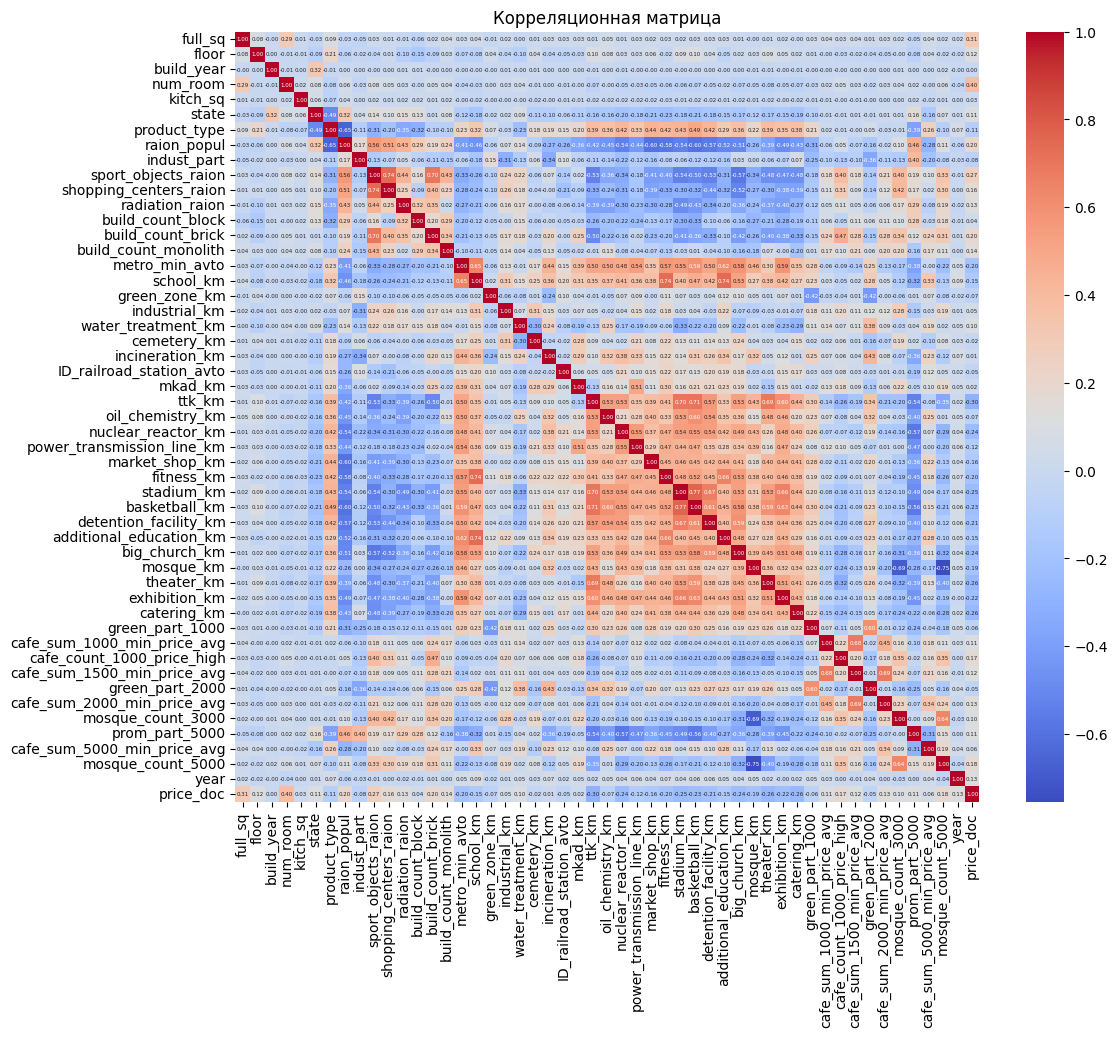

In [ ]:
# Исследуем данные по корреляционной матрице.

features_with_target = features
import seaborn as sns
plt.figure(figsize=(12, 10))
corr_matrix = df[features_with_target].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={"fontsize": 4})
plt.title('Корреляционная матрица')
plt.show()

# Обработка данных и выбросов
Изначально мы брали обычную линейную регрессию, и по отдельности смотрели, как можно обработать выбросы и аномальные значения у признаков, и так же выбрать наиболее значимые

Во-первых, просто обрезали по квантилям 5% крайних значений данных

In [ ]:
features = ['full_sq',
 'kitch_sq',
 'state',
 'build_count_monolith',
 'school_km',
 'industrial_km']

def remove_outliers_iqr(df, features):
    for feature in features:
        df = df[
            (df[feature] <= df[feature].quantile(0.95))
            & (df[feature] >= df[feature].quantile(0.05))
]
    return df

df = remove_outliers_iqr(df, features)

Во-вторых, с помощью z-скора

In [ ]:
from scipy import stats

def remove_outliers(df, features):
    df_clean = df.copy()
    for feature in features:
        z_scores = stats.zscore(df_clean[feature])
        abs_z_scores = abs(z_scores)
        filtered_entries = (abs_z_scores < 3)
        df_clean = df_clean[filtered_entries]
    return df_clean

df_clean = remove_outliers(df, features)

df_clean.shape

В-третьих, явным образом с помощью ящика с усами
Дальше идут функции для определения нужного диапазона

In [ ]:
def copy_by_feature(df, features):
  df_copy = pd.DataFrame()
  for feature in features:
    df_copy[feature] = df[feature]
  df_copy["price_doc"] = df['price_doc']
  return df_copy

In [ ]:
def Whisker_up(df, feature, up_q, down_q):
  quartile_3 = np.quantile(df[feature], q=up_q)
  quartile_1 = np.quantile(df[feature], q=down_q)
  whisker_up = quartile_3 + (quartile_3 - quartile_1) * 1.5
  return whisker_up

def Whisker_down(df, feature, up_q, down_q):
  quartile_3 = np.quantile(df[feature], q=up_q)
  quartile_1 = np.quantile(df[feature], q=down_q)
  whisker_down = quartile_1 - (quartile_3 - quartile_1) * 1.5
  return whisker_down

Неподходящие значения заменялись на медианные, если же в выбросы переходило слишком много значений, то диапазон увеличивался до нужного уровня (500 в примере)

In [ ]:
def remove_outliers(df, features, up_q, down_q):
  df_clean = df.copy()
  up_q1, down_q1 = up_q, down_q
  for feature in features:
    max = Whisker_up(df_clean, feature, up_q, down_q)
    min = Whisker_down(df_clean, feature, up_q, down_q)

    condition = (df_clean[feature] > max) | (df_clean[feature] < min)
    outliers = df[condition].shape[0]
    while outliers > 500:
      if up_q1 >= 99 or down_q1 <= 0.01:
        break
      up_q1 += 0.01
      down_q1 -= 0.01
      max = Whisker_up(df_clean, feature, up_q1, down_q1)
      min = Whisker_down(df_clean, feature, up_q1, down_q1)
      condition = (df_clean[feature] > max) | (df_clean[feature] < min)
      outliers = df[condition].shape[0]
    up_q1, down_q1 = up_q, down_q
    outliers = df[condition].shape[0]
    df_clean.loc[condition, feature] = df_clean[feature].median()

  return df_clean


In [ ]:
def remove_outliers2(df, features, up_q, down_q):
  df_clean = df.copy()
  up_q1, down_q1 = up_q, down_q
  for feature in features:
    max = Whisker_up(df_clean, feature, up_q, down_q)
    min = Whisker_down(df_clean, feature, up_q, down_q)
    df_clean = df_clean[(df_clean[feature] <= max) & (df_clean[feature] >= min)]

  return df_clean

In [ ]:
df_clean3 = remove_outliers(df, features, 0.80, 0.20)

full_sq   (397, 51)
floor   (50, 51)
build_year   (1, 51)
num_room   (325, 51)
kitch_sq   (113, 51)
state   (1, 51)
product_type   (0, 51)
raion_popul   (0, 51)
indust_part   (0, 51)
sport_objects_raion   (0, 51)
shopping_centers_raion   (462, 51)
radiation_raion   (0, 51)
build_count_block   (477, 51)
build_count_brick   (251, 51)
build_count_monolith   (476, 51)
metro_min_avto   (259, 51)
school_km   (405, 51)
green_zone_km   (487, 51)
industrial_km   (157, 51)
water_treatment_km   (3, 51)
cemetery_km   (109, 51)
incineration_km   (320, 51)
ID_railroad_station_avto   (236, 51)
mkad_km   (149, 51)
ttk_km   (381, 51)
oil_chemistry_km   (100, 51)
nuclear_reactor_km   (19, 51)
power_transmission_line_km   (6, 51)
market_shop_km   (26, 51)
fitness_km   (445, 51)
stadium_km   (35, 51)
basketball_km   (7, 51)
detention_facility_km   (45, 51)
additional_education_km   (481, 51)
big_church_km   (70, 51)
mosque_km   (96, 51)
theater_km   (110, 51)
exhibition_km   (106, 51)
catering_km   (202, 

In [ ]:
df_clean3.describe()

,full_sq,floor,build_year,num_room,kitch_sq,state,product_type,raion_popul,indust_part,sport_objects_raion,...,cafe_count_1000_price_high,cafe_sum_1500_min_price_avg,green_part_2000,cafe_sum_2000_min_price_avg,mosque_count_3000,prom_part_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,year,price_doc
count,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,...,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,2.132900e+04
mean,52.044306,7.601716,1924.621361,1.903652,5.854892,2.060153,0.359276,10.899731,0.119305,6.581884,...,0.045384,6.547179,2.809511,6.545070,0.197900,2.208003,6.615003,0.442496,2013.449388,6.653259e+06
std,17.068319,5.178045,333.863035,0.628283,3.155449,0.633442,0.479800,1.151518,0.119186,6.514278,...,0.230998,0.223736,0.736131,0.205040,0.445642,0.554558,0.162117,0.607982,0.961555,3.190145e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.842279,0.000000,0.000000,...,0.000000,5.828946,0.095310,5.857933,0.000000,0.307485,6.177571,0.000000,2011.000000,1.000000e+05
25%,38.000000,3.000000,1976.000000,2.000000,5.000000,2.000000,0.000000,9.990536,0.019509,1.000000,...,0.000000,6.417549,2.369309,6.428816,0.000000,1.818077,6.509142,0.000000,2013.000000,4.745995e+06
50%,49.000000,6.500000,1979.000000,2.000000,6.000000,2.000000,0.000000,11.332626,0.072158,5.000000,...,0.000000,6.540034,2.865054,6.526978,0.000000,2.195000,6.581665,0.000000,2014.000000,6.255454e+06
75%,62.000000,11.000000,1983.000000,2.000000,8.000000,2.000000,1.000000,11.718817,0.195781,10.000000,...,0.000000,6.666588,3.341447,6.652863,0.000000,2.636912,6.685811,1.000000,2014.000000,8.000000e+06
max,113.000000,25.000000,2018.000000,3.000000,18.000000,4.000000,1.000000,12.419041,0.521867,29.000000,...,2.000000,7.256064,4.321480,7.200425,2.000000,3.352007,7.135337,2.000000,2015.000000,1.885000e+07


In [ ]:
features1 = features[0:10]
df_1 = copy_by_feature(df, features1)
df_clean3_1 = copy_by_feature(df_clean3, features1)

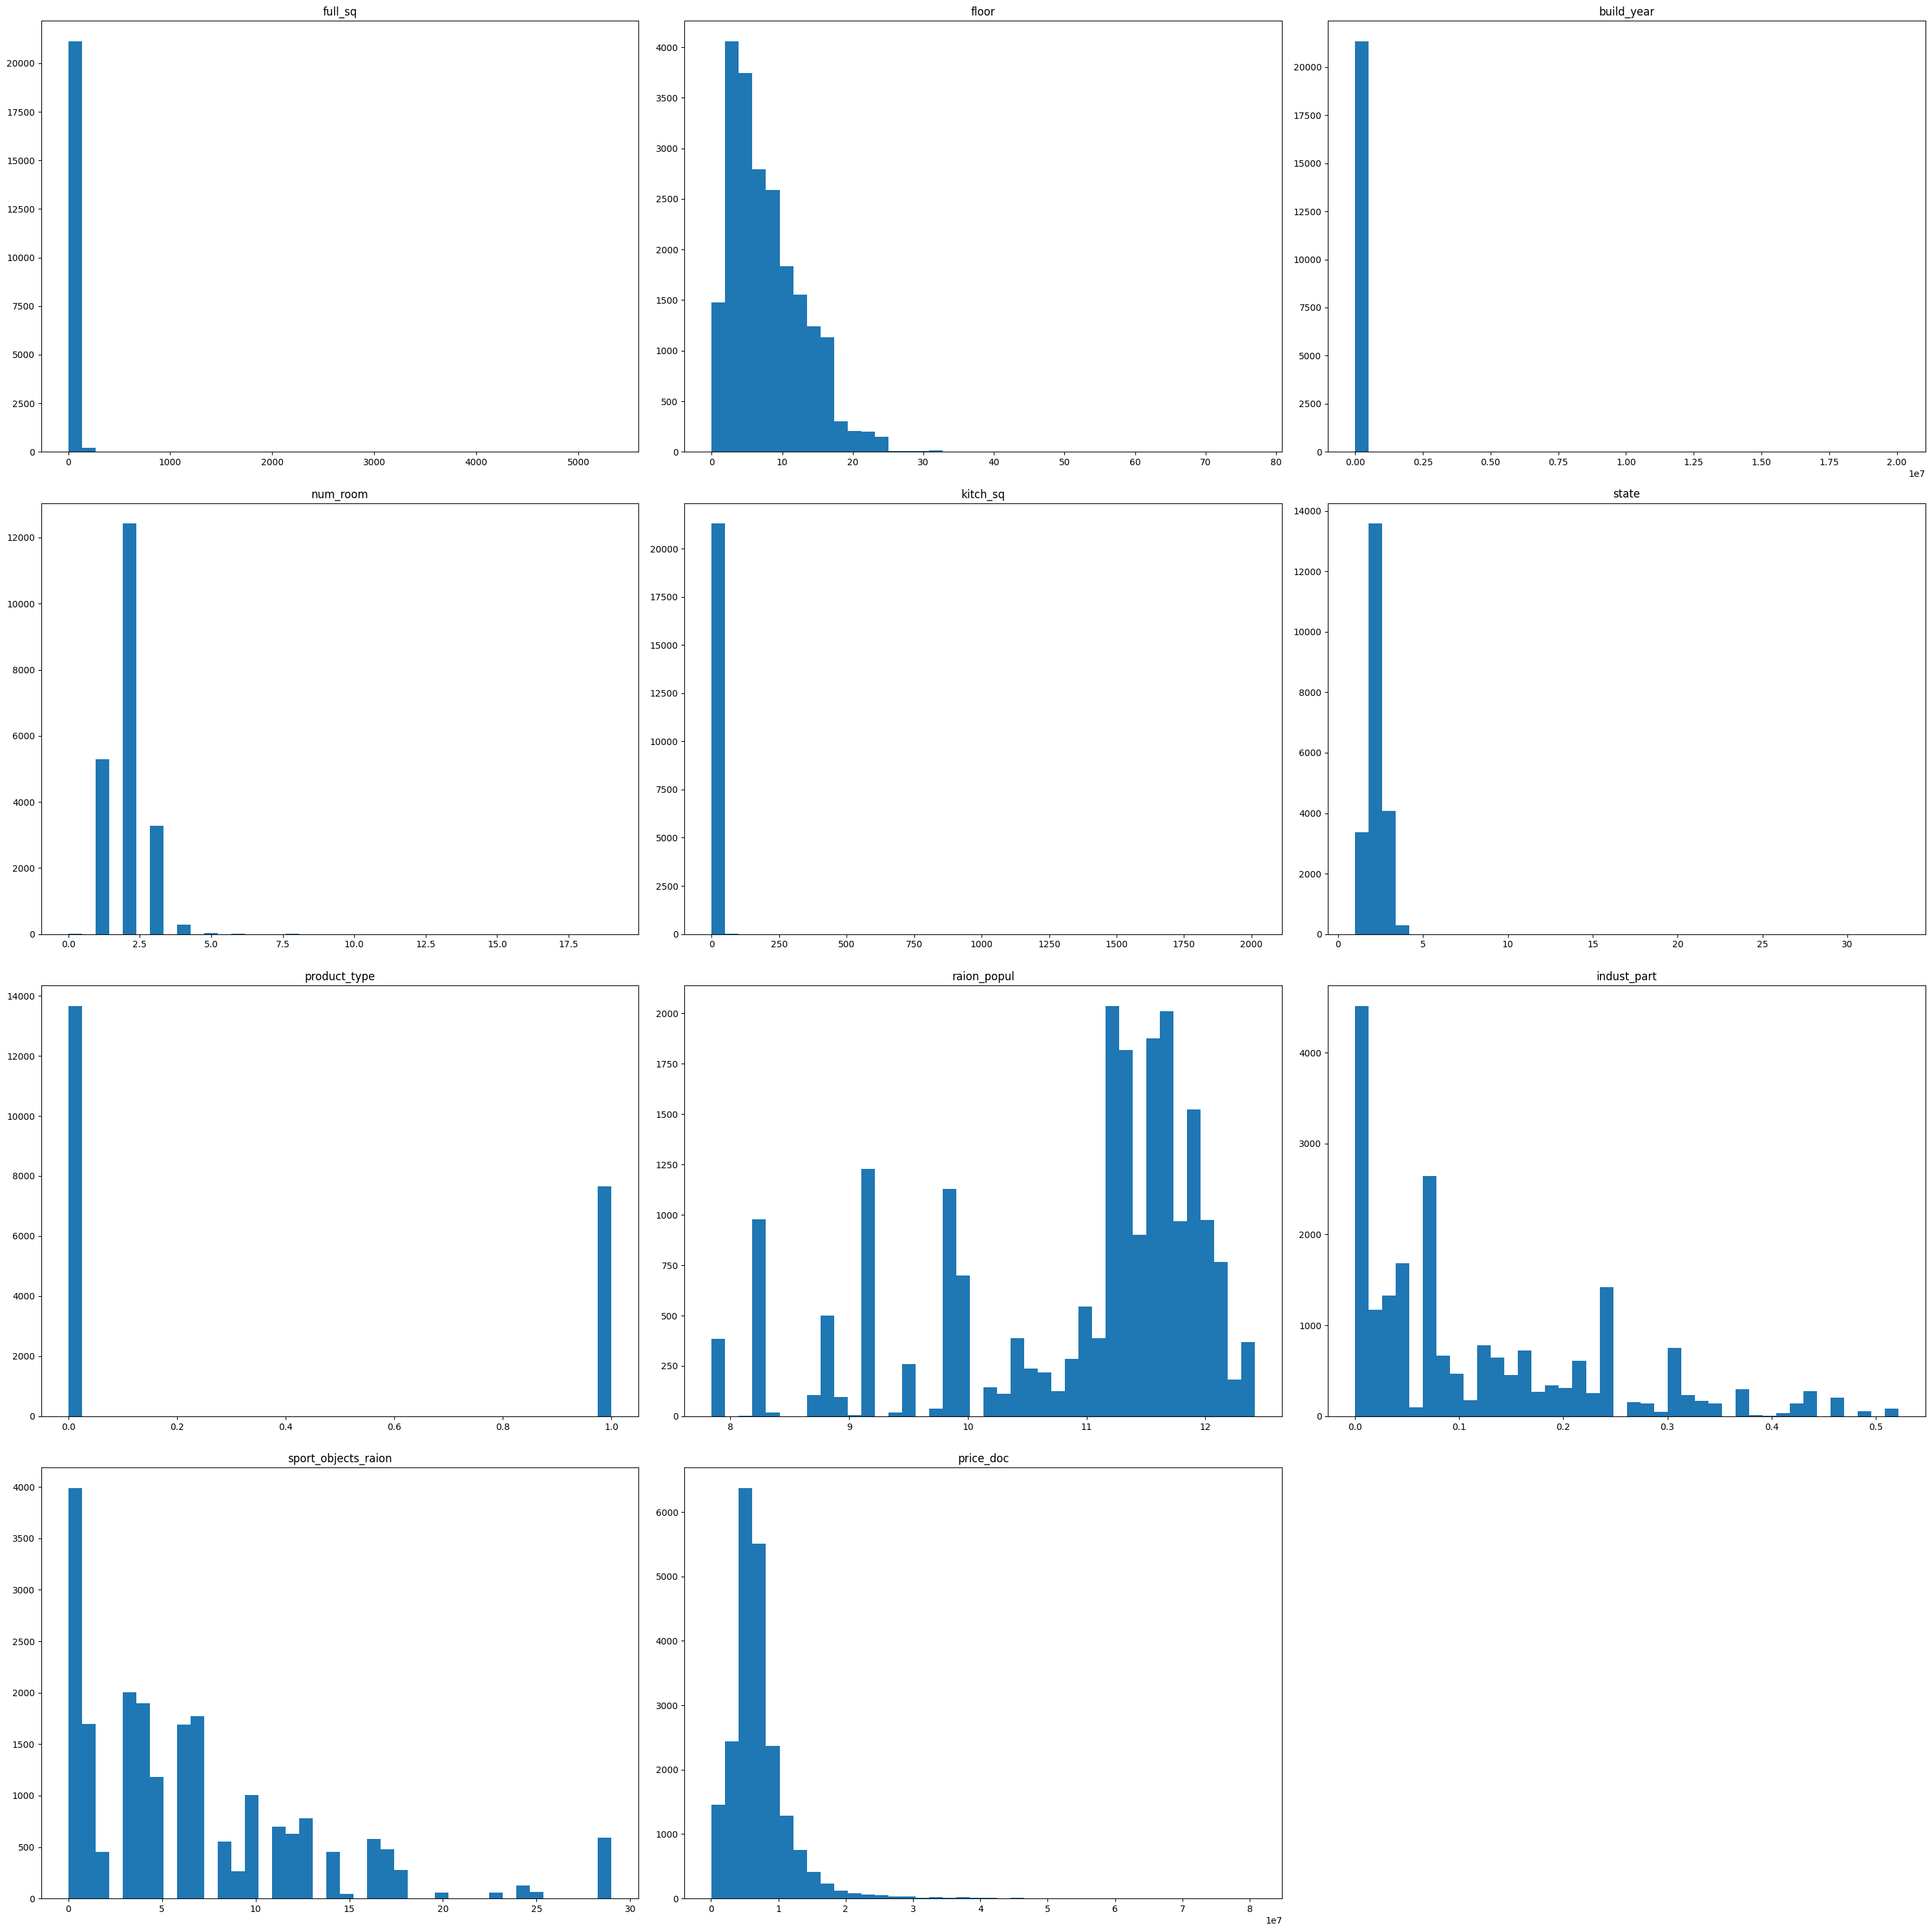

In [ ]:
df_1.hist(figsize=(30,30), bins=40, grid=False)
plt.tight_layout()

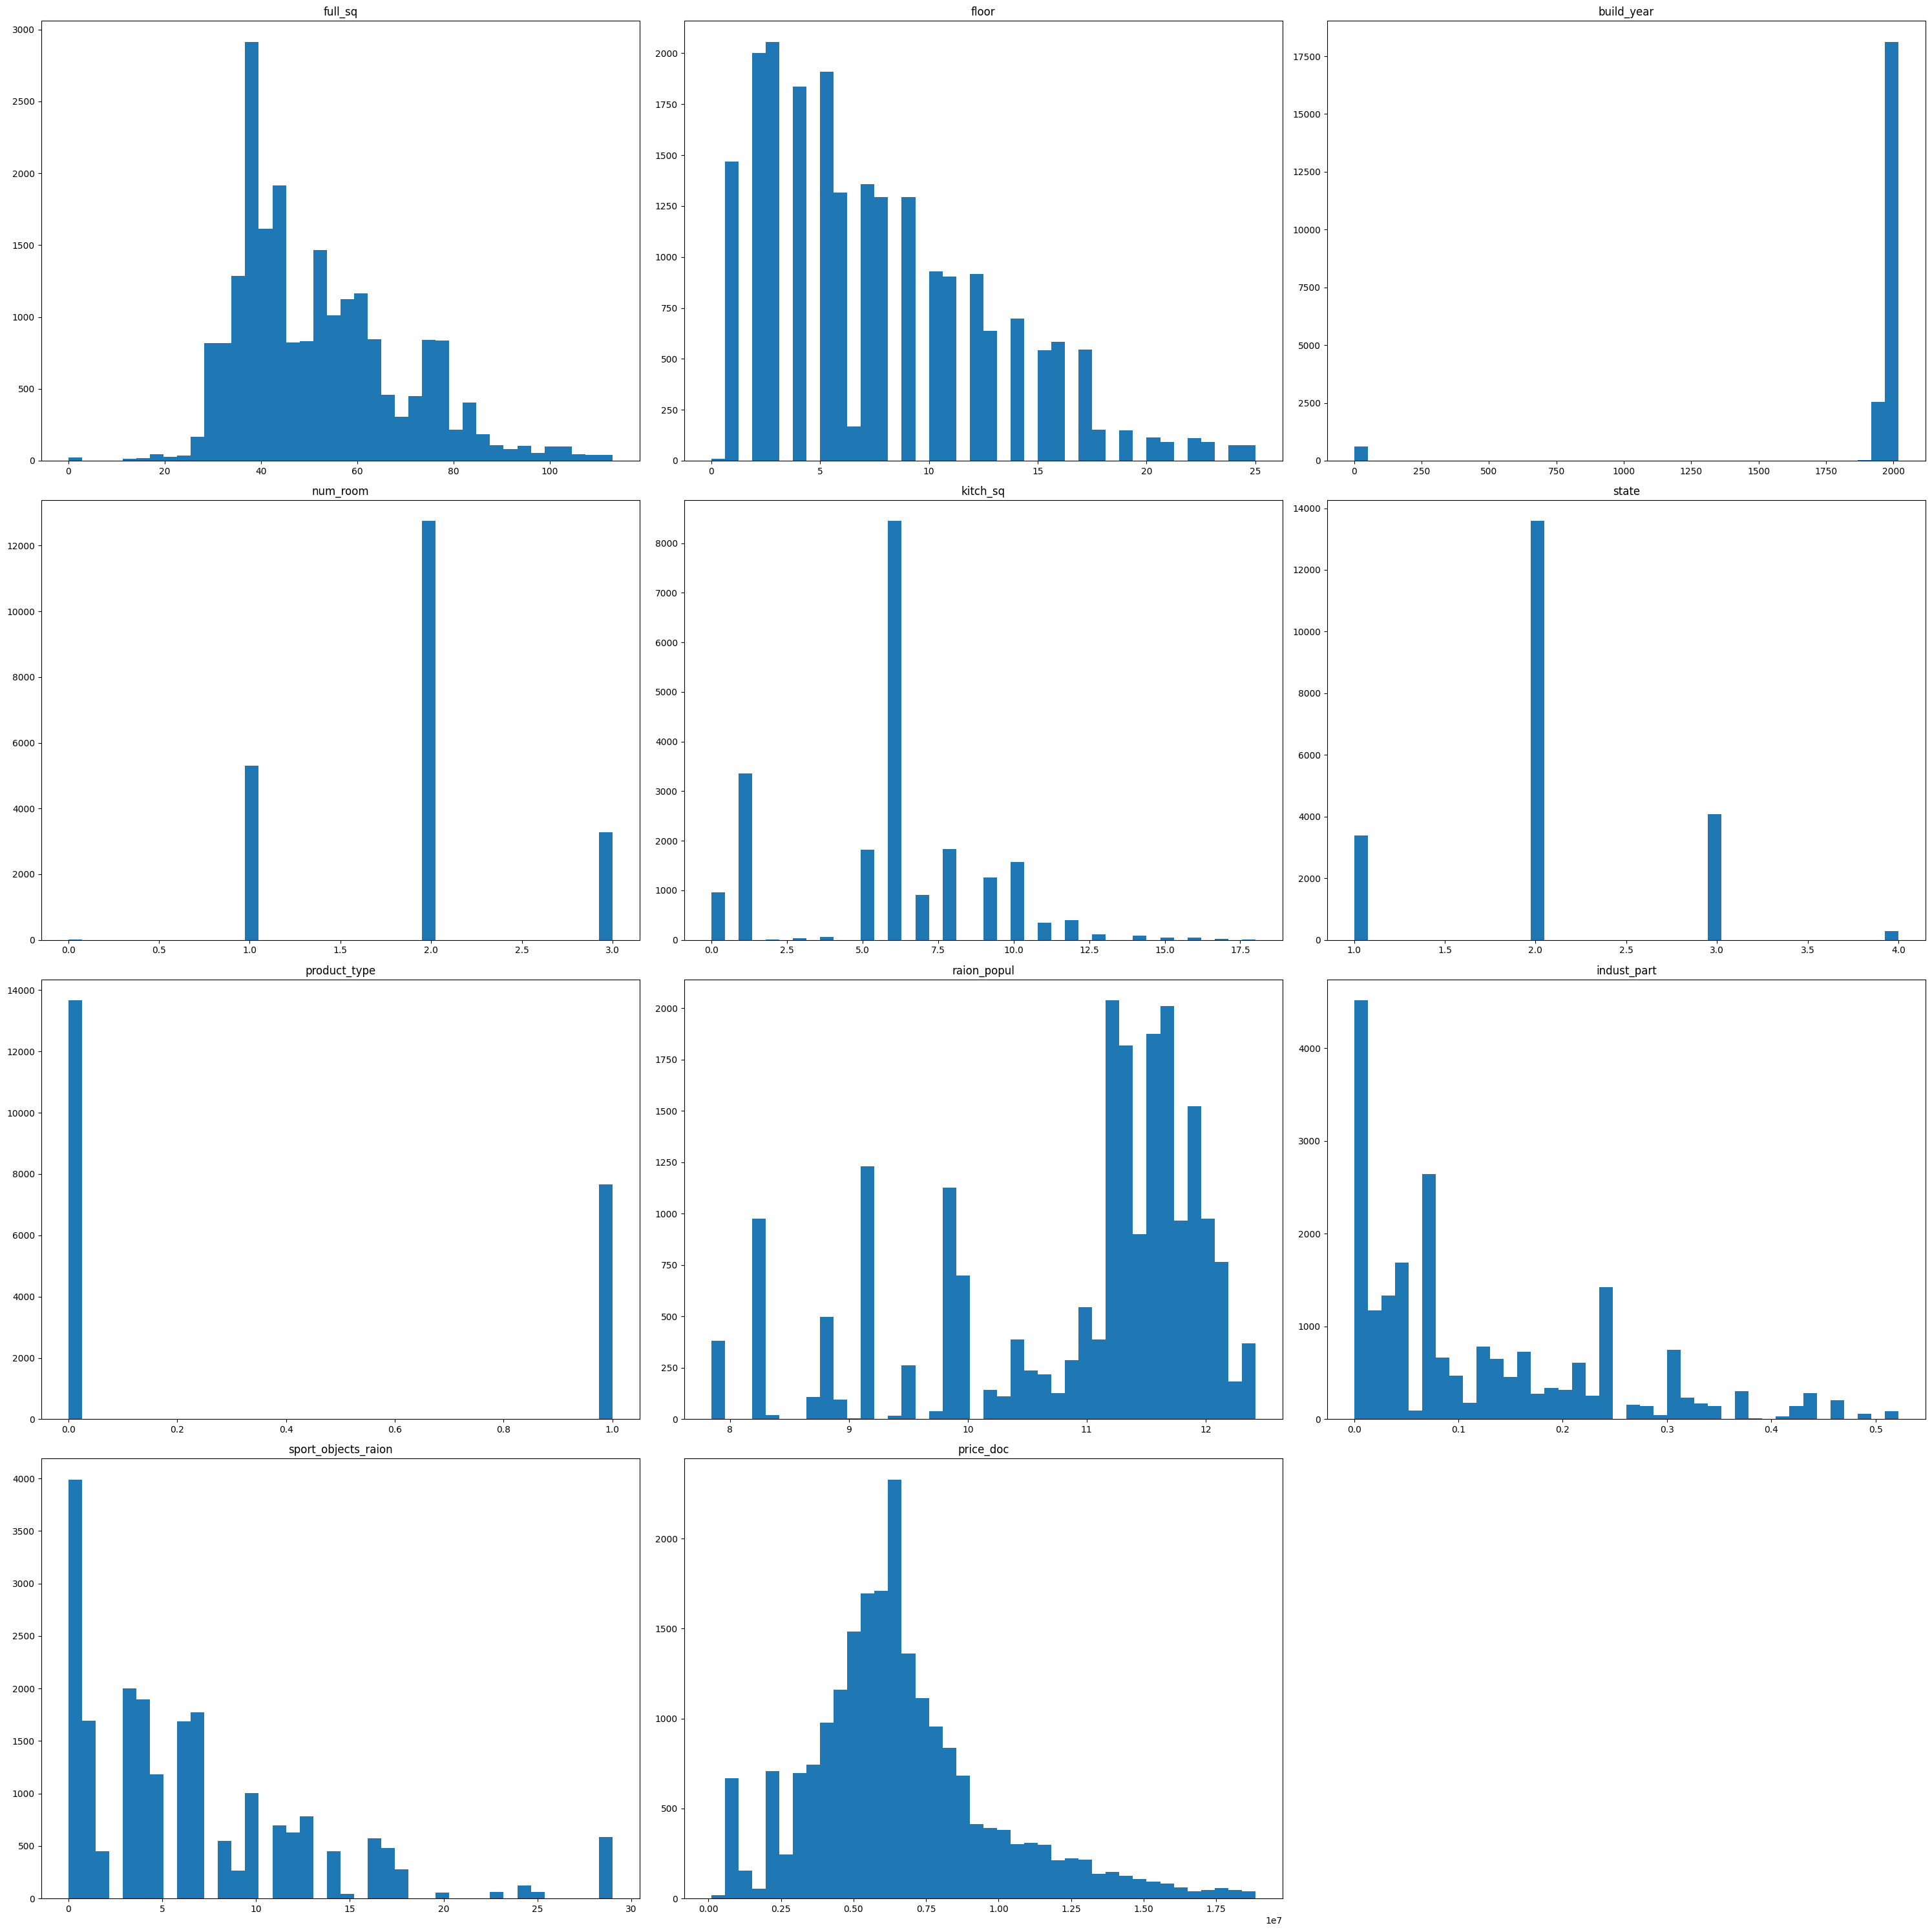

In [ ]:
df_clean3_1.hist(figsize=(30,30), bins=40, grid=False)
plt.tight_layout()

In [ ]:
# Все столбцы кроме последнего
X = df_clean3.iloc[:, :-1]
y = df_clean3.iloc[:, -1]   # Только последний столбец

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стадартизация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Средняя абсолютная ошибка (MAE): 1548936.39
Среднеквадратичная ошибка (MSE): 5480286171860.56
Корень из среднеквадратичной ошибки (RMSE): 2341001.10
Коэффициент детерминации (R^2): 0.46


Стало ясно, что обрезать данные нужно совсем немного, поэтому мы вручную задали часть ограничений на явно неправильные значения, и с помощью усов, но с широким диапазоном

In [ ]:
mean_full_sq = df['full_sq'].mean()
mean_kitch_sq = df['kitch_sq'].mean()
mean_build_year = df['build_year'].mean()

df_clean4.loc[df['full_sq'] > 250, 'full_sq'] = mean_full_sq
df_clean4.loc[df['kitch_sq'] > 50, 'kitch_sq'] = mean_kitch_sq
df_clean4.loc[df['build_year'] > 2024, 'build_year'] = mean_build_year

In [ ]:
Q1 = df.quantile(0.05)
Q3 = df.quantile(0.95)
IQR = Q3 - Q1

In [ ]:
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

In [ ]:
df_clean5 = df[~outliers.any(axis=1)]

In [ ]:
# Отделение целевой переменной
X = df_clean5.drop(columns=['price_doc'])
y = df_clean5['price_doc']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Генерация новых характеристик

Мы сгенерировали ряд новых характеристик, добавили их в датафрейм и обучали модели. Однако это не привело к улучшению качества обучения. Поэтому от добавления новых фичей приняли решение отказаться.

In [ ]:
df['liv_sq_per_room'] = (df['full_sq'] - df['kitch_sq']) / df['num_room']
df['kitch_sq_per_room'] = df['kitch_sq'] / df['num_room']
df['living_sq'] = df['full_sq'] - df['kitch_sq']
df['living_area_ratio'] = df['living_sq'] / df['full_sq']
df['floor_ratio'] = df['floor'] / (df['build_count_block'] + df['build_count_brick'] + df['build_count_monolith'])
df['building_age'] = 2024 - df['build_year']
df['distance_to_green'] = df['green_zone_km'] + df['green_part_1000']
df['cafes_per_1000'] = df['cafe_sum_1000_min_price_avg'] / (df['raion_popul'] / 1000)
df['industrial_density'] = df['indust_part'] / df['raion_popul']
df['avg_sport_km'] = df[['fitness_km', 'stadium_km', 'basketball_km']].mean(axis=1)
df['avg_culture_km'] = df[['theater_km', 'exhibition_km']].mean(axis=1)
df['education_avg'] = df[['school_km', 'additional_education_km']].mean(axis=1)
df['transport_accessibility'] = (df['mkad_km'] + df['ttk_km']) / df['metro_min_avto']
df['ecology_idx'] = df['water_treatment_km'] / df['green_zone_km']

# Выбор модели
Мы протестировали линейную регрессию, её L1-регуляризацию, XGBoost , случайный лес и catboost.

## Линейная регрессия

In [ ]:
X=df_clean4.drop('price_doc',axis=1)
y=df_clean4['price_doc']

In [ ]:
# Standardize features by removing the mean and scaling to unit variance.
# The standard score of a sample x is calculated as:
#       z = (x - u) / s
transformer = StandardScaler().fit(X)
X_prep = transformer.transform(X)
[30]
X_prep.shape

(19307, 50)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
model_lasso = Lasso(alpha=1)
model_lasso.fit(X_train, y_train)

Lasso(alpha=1)

In [ ]:
model_lasso_cv = LassoCV(eps=0.001, n_alphas=1000, cv=10, max_iter=10000)

In [ ]:
model_lasso_cv.fit(X_train, y_train)

print("alpha: ", model_lasso_cv.alpha_)

alpha:  3855.7429501661622


In [ ]:
# Predict on validation data
pred_val_lasso2 = model_lasso_cv.predict(X_val)

r2_val2_lasso = r2_score(y_val, pred_val_lasso2)
mse_val2_lasso = mean_squared_error(y_val, pred_val_lasso2)
rmse_val2_lasso = np.sqrt(mse_val2_lasso)
mae_val2_lasso = mean_absolute_error(y_val, pred_val_lasso2)

In [ ]:
print('R2 Score: ', r2_val2_lasso)
print('MSE: ', mse_val2_lasso)
print('RMSE: ', rmse_val2_lasso)
print('MAE: ', mae_val2_lasso)

R2 Score:  0.579361923019055
MSE:  5788473483533.201
RMSE:  2405924.662896409
MAE:  1555345.9263346444


In [ ]:
# Finally, predict on test data
pred_test_lasso = model_lasso_cv.predict(X_test)

r2_test_lasso = r2_score(y_test, pred_test_lasso)
mse_test_lasso = mean_squared_error(y_test, pred_test_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)
mae_test_lasso = mean_absolute_error(y_test, pred_test_lasso)

print('R2 Score: ', r2_test_lasso)
print('MSE: ', mse_test_lasso)
print('RMSE: ', rmse_test_lasso)
print('MAE: ', mae_test_lasso)

R2 Score:  0.5277208225364828
MSE:  6459570464765.96
RMSE:  2541568.504834359
MAE:  1640100.8883997325


In [ ]:
model_xgbr = XGBRegressor(objective ='reg:squarederror', n_estimators = 16, seed = 0, max_depth = 7)

model_xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=16, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predict on train data
pred_train_xgbr = model_xgbr.predict(X_train)

r2_train_xgbr = r2_score(y_train, pred_train_xgbr)
mse_train_xgbr = mean_squared_error(y_train, pred_train_xgbr)
rmse_train_xgbr = np.sqrt(mse_train_xgbr)
mae_train_xgbr = mean_absolute_error(y_train, pred_train_xgbr)

In [ ]:
# Predict on validation data
pred_val_xgbr = model_xgbr.predict(X_val)

r2_val_xgbr = r2_score(y_val, pred_val_xgbr)
mse_val_xgbr = mean_squared_error(y_val, pred_val_xgbr)
rmse_val_xgbr = np.sqrt(mse_val_xgbr)
mae_val_xgbr = mean_absolute_error(y_val, pred_val_xgbr)

In [ ]:
pd.DataFrame({'Validation':  [r2_val_xgbr, mse_val_xgbr, rmse_val_xgbr, mae_val_xgbr],
               'Training': [r2_train_xgbr, mse_train_xgbr, rmse_train_xgbr, mae_train_xgbr],
             },
              index=['R2', 'MSE', 'RMSE', 'MAE'])

,Validation,Training
R2,6.161182e-01,8.403458e-01
MSE,5.282664e+12,2.265114e+12
RMSE,2.298405e+06,1.505030e+06
MAE,1.354124e+06,9.657719e+05


In [ ]:
# Finally, predict on test data
pred_test_xgbr = model_xgbr.predict(X_test)

r2_test_xgbr = r2_score(y_test, pred_test_xgbr)
mse_test_xgbr = mean_squared_error(y_test, pred_test_xgbr)
rmse_test_xgbr = np.sqrt(mse_test_xgbr)
mae_test_xgbr = mean_absolute_error(y_test, pred_test_xgbr)

print('R2 Score: ', r2_test_xgbr)
print('MSE: ', mse_test_xgbr)
print('RMSE: ', rmse_test_xgbr)
print('MAE: ', mae_test_xgbr)

R2 Score:  0.5651391517892879
MSE:  5947783483640.841
RMSE:  2438807.799651469
MAE:  1447624.2743397204


## Randomforest

Перед этим были просмотрены распределения по признакам и данные, которые были в признаках, но не были по факту в самих распределениях. Они были удалены через .drop(). В качестве гиперпараметра выбрано число деревьев и дальнейшая их настройка не проводилась, поскольку финальный результат вышел хуже, чем у модели Catboost, однако результат в метриках получился сбалансированным.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Средняя абсолютная ошибка (MAE): {mae_rf:.2f}")
print(f"Random Forest - Среднеквадратичная ошибка (MSE): {mse_rf:.2f}")
print(f"Random Forest - Корень из среднеквадратичной ошибки (RMSE): {rmse_rf:.2f}")


mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Средняя абсолютная ошибка (MAE): {mae_rf:.2f}")
print(f"Random Forest - Среднеквадратичная ошибка (MSE): {mse_rf:.2f}")
print(f"Random Forest - Корень из среднеквадратичной ошибки (RMSE): {rmse_rf:.2f}")
print(f"Random Forest - Коэффициент детерминации (R^2): {r2_rf:.2f}")
Random Forest - Средняя абсолютная ошибка (MAE): 1390537.47
Random Forest - Среднеквадратичная ошибка (MSE): 6116729781912.01
Random Forest - Корень из среднеквадратичной ошибки (RMSE): 2473202.33
Random Forest - Коэффициент детерминации (R^2): 0.65print(f"Random Forest - Коэффициент детерминации (R^2): {r2_rf:.2f}")

Random Forest - Средняя абсолютная ошибка (MAE): 1390537.47
Random Forest - Среднеквадратичная ошибка (MSE): 6116729781912.01
Random Forest - Корень из среднеквадратичной ошибки (RMSE): 2473202.33
Random Forest - Коэффициент детерминации (R^2): 0.65


## Catboost

In [ ]:
# Отделение целевой переменной
X = df.drop(columns=['price_doc'])
y = df['price_doc']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели CatBoost
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=True)

# Предсказание и оценка модели
y_pred = model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"CatBoostRegressor - Корень из среднеквадратичной ошибки (RMSE): {rmse_rf:.2f}")
print(f"CatBoostRegressor - Коэффициент детерминации (R^2): {r2_rf:.2f}")

Так как Catboost показал лучшие результаты при оценке, было решено ещё раз обработать данные, заменив неадекватные значения на NaN, с которыми он умеет работать

In [ ]:
df_clean5 = copy_by_feature(df, features)

In [ ]:
df_clean5['full_sq'].value_counts(bins=60, sort = False)

full_sq
(-5.327, 88.767]        20281
(88.767, 177.533]        1010
(177.533, 266.3]           30
(266.3, 355.067]            3
(355.067, 443.833]          0
(443.833, 532.6]            1
(532.6, 621.367]            1
(621.367, 710.133]          1
(710.133, 798.9]            1
(798.9, 887.667]            0
(887.667, 976.433]          0
(976.433, 1065.2]           0
(1065.2, 1153.967]          0
(1153.967, 1242.733]        0
(1242.733, 1331.5]          0
(1331.5, 1420.267]          0
(1420.267, 1509.033]        0
(1509.033, 1597.8]          0
(1597.8, 1686.567]          0
(1686.567, 1775.333]        0
(1775.333, 1864.1]          0
(1864.1, 1952.867]          0
(1952.867, 2041.633]        0
(2041.633, 2130.4]          0
(2130.4, 2219.167]          0
(2219.167, 2307.933]        0
(2307.933, 2396.7]          0
(2396.7, 2485.467]          0
(2485.467, 2574.233]        0
(2574.233, 2663.0]          0
(2663.0, 2751.767]          0
(2751.767, 2840.533]        0
(2840.533, 2929.3]          0
(2

In [ ]:

df_clean5.loc[df_clean5['full_sq'] > 800, 'full_sq'] = np.NaN
df_clean5.loc[df_clean5['full_sq'] < 5, 'full_sq'] = np.NaN

In [ ]:
df_clean5.loc[df_clean5['kitch_sq'] > 50, 'kitch_sq'] = np.NaN
df_clean5.loc[df_clean5['kitch_sq'] < 0, 'kitch_sq'] = np.NaN

In [ ]:
df_clean5.loc[df_clean5['build_year'] > 2024, 'build_year'] = np.NaN
df_clean5.loc[df_clean5['build_year'] < 1700, 'build_year'] = np.NaN

In [ ]:
df_clean5.loc[df_clean5['num_room'] < 1, 'num_room'] = np.NaN

In [ ]:
df_clean5.loc[df_clean5['water_treatment_km'] < 0, 'water_treatment_km'] = abs(df_clean['water_treatment_km'])

In [ ]:
df_clean5.loc[df_clean5['state'] > 5, 'state'] = np.NaN

In [ ]:
features_km = ['incineration_km', 'ttk_km', 'oil_chemistry_km', 'nuclear_reactor_km', 'power_transmission_line_km',
               'market_shop_km', 'fitness_km', 'stadium_km', 'basketball_km', 'detention_facility_km', 'big_church_km', 'mosque_km', 'theater_km', 'exhibition_km', 'catering_km']

In [ ]:
for feature in features_km:
  df_clean5.loc[df_clean5[feature] < 0, feature] = np.NaN

In [ ]:
Q1 = df_clean5.quantile(0.05)
Q3 = df_clean5.quantile(0.95)
IQR = Q3 - Q1

In [ ]:
outliers = (df_clean5 < (Q1 - 1.8* IQR)) | (df_clean5 > (Q3 + 1.8 * IQR))
print(outliers)

In [ ]:
df_clean6 = df_clean5[~outliers.any(axis=1)]

In [ ]:
# Отделение целевой переменной
X = df_clean.drop(columns=['price_doc'])
y = df_clean['price_doc']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Создание и обучение модели CatBoost
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=True)

# Предсказание и оценка модели
y_pred = model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"CatBoostRegressor - Корень из среднеквадратичной ошибки (RMSE): {rmse_rf:.2f}")
print(f"CatBoostRegressor - Коэффициент детерминации (R^2): {r2_rf:.2f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4094885.2975915	test: 4086319.8562251	best: 4086319.8562251 (0)	total: 23.2ms	remaining: 23.1s
100:	learn: 2175792.5965029	test: 2445423.9990258	best: 2445423.9990258 (100)	total: 1.29s	remaining: 11.5s
200:	learn: 1971800.7827506	test: 2392372.8881992	best: 2392301.1122389 (199)	total: 2.52s	remaining: 10s
300:	learn: 1845791.9027132	test: 2376876.9995055	best: 2376656.2151457 (297)	total: 3.78s	remaining: 8.77s
400:	learn: 1744436.0998148	test: 2369774.0123067	best: 2368398.7362905 (338)	total: 5.1s	remaining: 7.61s
500:	learn: 1662891.9860718	test: 2364158.2652298	best: 2364158.2652298 (500)	total: 6.93s	remaining: 6.9s
600:	learn: 1590399.4486648	test: 2363383.5566813	best: 2363383.5566813 (600)	total: 9.82s	remaining: 6.52s
700:	learn: 1525345.2748739	test: 2364308.2554726	best: 2360544.6264491 (634)	total: 11.4s	remaining: 4.87s
800:	learn: 1465903.6892131	test: 2365180.7311697	best: 2360544.6264491 (634)	total: 12.7s	remaining: 3.15s
900:	learn: 1411916.6419423	test: 2

# Выводы

В результате был проведен разведочный анализ данных и выполнено обучение с использованием трех моделей, из которых была выбрана модель Catboost для сабмита.

Предобработка данных, обучение модели и сабмит показаны в ноутбуке Русичи_model.